In [1]:
!pip install requests

In [1]:
import numpy as np
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

/Users/ccaspar/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [ ]:
# goals
# NFL side and total
# - % bets
# - % money
# - line history

In [2]:
# map variations to standard team name
def map_team_name(team):
    team_abbreviation_mapping = {
        'Arizona Cardinals': 'ARI',
        'ArizonaCardinals': 'ARI',
        'Atlanta Falcons': 'ATL',
        'AtlantaFalcons': 'ATL',
        'Baltimore Ravens': 'BAL',
        'BaltimoreRavens': 'BAL',
        'Buffalo Bills': 'BUF',
        'BuffaloBills': 'BUF',
        'Carolina Panthers': 'CAR',
        'CarolinaPanthers': 'CAR',
        'Chicago Bears': 'CHI',
        'ChicagoBears': 'CHI',
        'Cincinnati Bengals': 'CIN',
        'CincinnatiBengals': 'CIN',
        'Cleveland Browns': 'CLE',
        'ClevelandBrowns': 'CLE',
        'Dallas Cowboys': 'DAL',
        'DallasCowboys': 'DAL',
        'Denver Broncos': 'DEN',
        'DenverBroncos': 'DEN',
        'Detroit Lions': 'DET',
        'DetroitLions': 'DET',
        'Green Bay Packers': 'GBP',
        'Green BayPackers': 'GBP',
        'Houston Texans': 'HOU',
        'HoustonTexans': 'HOU',
        'Indianapolis Colts': 'IND',
        'IndianapolisColts': 'IND',
        'Jacksonville Jaguars': 'JAC',
        'JacksonvilleJaguars': 'JAC',
        'Kansas City Chiefs': 'KCC',
        'Kansas CityChiefs': 'KCC',
        'Los Angeles Chargers': 'LAC',
        'L.A. ChargersChargers': 'LAC',
        'Los Angeles Rams': 'LAR',
        'L.A. RamsRams': 'LAR',
        'Las Vegas Raiders': 'LVR',
        'Las VegasRaiders': 'LVR',
        'Miami Dolphins': 'MIA',
        'MiamiDolphins': 'MIA',
        'Minnesota Vikings': 'MIN',
        'MinnesotaVikings': 'MIN',
        'New York Giants': 'NYG',
        'N.Y. GiantsGiants': 'NYG',
        'New York Jets': 'NYJ',
        'N.Y. JetsJets': 'NYJ',
        'New England Patriots': 'NEP',
        'New EnglandPatriots': 'NEP',
        'New Orleans Saints': 'NOS',
        'New OrleansSaints': 'NOS',
        'Philadelphia Eagles': 'PHI',
        'PhiladelphiaEagles': 'PHI',
        'Pittsburgh Steelers': 'PIT',
        'PittsburghSteelers': 'PIT',
        'San Francisco 49ers': 'SFO',
        'San Francisco49ers': 'SFO',
        'Seattle Seahawks': 'SEA',
        'SeattleSeahawks': 'SEA',
        'Tampa Bay Buccaneers': 'TBB',
        'Tampa BayBuccaneers': 'TBB',
        'Tennessee Titans': 'TEN',
        'TennesseeTitans': 'TEN',
        'Washington Commanders': 'WAS',
        'WashingtonCommanders': 'WAS',
    }

    standardized_name = team_abbreviation_mapping.get(team)
    if standardized_name:
        return standardized_name
    else:
        print(f'No team match for {team}')
        return team

In [3]:
# scraping function
def scrape_for_soup(base_url, url):
    # send GET request
    response = requests.get(base_url+url)

    # status check
    if response.status_code != 200:
        return(f"Error: {response.status_code}")

    # parse HTML
    soup = BeautifulSoup(response.text, 'html.parser')
    return soup


# odds data scrape
def pull_odds_data(week_num):
    base_url = 'https://www.sportsbookreview.com'
    url = f'/betting-odds/nfl-football/?week=Week{week_num}'
    soup = scrape_for_soup(base_url, url)

    # parse links for game spread and spread history
    games = soup.find_all('div', id='tbody-nfl')
    main_links = set()
    line_links = set()
    for game in games:
        for a_tag in game.find_all('a', href=True):
            link = a_tag['href']
            if 'scores' in link:
                main_links.add(link)
            if 'line-history' in link:
                line_links.add(link)
                
    game_list = []
    # iterate through each link to scrape target data
    for game_url in list(main_links):
        # send request
        game_soup = scrape_for_soup(base_url, game_url)

        # over/under bets
        total_bets = game_soup.find('div', text=re.compile('Total'))
        over_perc = float(total_bets.previous_sibling.get_text()[:-3])
        under_perc = float(total_bets.next_sibling.get_text()[:-3])
        # pull total
        tot_div = game_soup.find('div', class_='row GameMatchup_mainColumn__cILb0')
        # find the span that contains the best total for the over and strip the first element (second element is odds if needed)
        total = float(tot_div.find('h4', text='Over').find_parent('div').find_next_sibling('div').find('span').contents[0].strip())

        # teams
        away_div = game_soup.find('div', class_=re.compile('TeamName'))
        home_div = game_soup.find('div', class_=re.compile('TeamName')).findNext('div', class_=re.compile('TeamName'))
        home_team = map_team_name(re.findall('.+?(?=\+|-|PK)',home_div.get_text())[0])
        away_team = map_team_name(re.findall('.+?(?=\+|-|PK)',away_div.get_text())[0])
        # spread bets
        spread = game_soup.find('div', text=re.compile('Spread'))
        home_perc = float(spread.next_sibling.get_text()[:-1])
        away_perc = float(spread.previous_sibling.get_text()[:-1])
        home_spread = home_div.find(class_='h5 mb-2 text-secondary opacity-75').text
        # home_spread = home_div.find(text=re.compile('\+?\-?\d+\.?\d*'))
        away_spread = away_div.find(class_='h5 mb-2 text-secondary opacity-75').text
        # away_spread = away_div.find(text=re.compile('\+?\-?\d+\.?\d*'))

        # add data to df
        row = {}
        row['week'] = int(week_num)
        row['home_team'] = home_team
        row['away_team'] = away_team
        row['home_spread'] = home_spread
        row['home_percent'] = home_perc
        row['away_percent'] = away_perc
        row['total'] = total
        row['over_percent'] = over_perc
        row['under_percent'] = under_perc
        game_list.append(row)
        
    odds_df = pd.DataFrame(game_list)
    return odds_df


# results data scrape
def pull_result_data(week_num, year):
    # pull game results
    season_type = '2'
    url = f'https://site.api.espn.com/apis/site/v2/sports/football/nfl/scoreboard?dates={year}&seasontype={season_type}&week={week_num}'
    result = requests.get(url)
    json_result = result.json()

    result_list = []
    for event in json_result['events']:
        game = event['competitions'][0]
        result = {}
        for team in game['competitors']:
            ha = team['homeAway']
            if ha == 'home':
                home_team = map_team_name(team['team']['displayName'])
                home_score = team['score']
            else:
                away_team = map_team_name(team['team']['displayName'])
                away_score = team['score']

        result['home_team'] = home_team
        result['home_score'] = int(home_score)
        result['away_team'] = away_team
        result['away_score'] = int(away_score)
        result_list.append(result)
        
    results_df = pd.DataFrame(result_list)
    return results_df


# determine who covered the spread
def spread_outcome(x):
    if x['home_score'] - x['away_score'] + float(x['home_spread']) > 0:
        return x['home_team']
    if x['home_score'] - x['away_score'] + float(x['home_spread']) < 0:
        return x['away_team']
    if x['home_score'] - x['away_score'] + float(x['home_spread']) == 0:
        return 'push'
    else:
        return 'error'


# determine over/under
def total_outcome(x):
    if x['home_score'] + x['away_score'] > x['total']:
        return 'over'
    if x['home_score'] + x['away_score'] < x['total']:
        return 'under'
    if x['home_score'] + x['away_score'] == x['total']:
        return 'push'
    else:
        return 'error'


# numerical did home team cover spread
def home_win(x):
    if x['home_score'] - x['away_score'] + float(x['home_spread']) > 0:
        return 1
    if x['home_score'] - x['away_score'] + float(x['home_spread']) < 0:
        return -1
    if x['home_score'] - x['away_score'] + float(x['home_spread']) == 0:
        return 0
    else:
        return 'error'


# numerical did favorite cover spread
def favorite_win(x):
    if float(x['home_spread']) > 0: 
        if x['home_score'] - x['away_score'] + float(x['home_spread']) > 0:
            return 1
        if x['home_score'] - x['away_score'] + float(x['home_spread']) < 0:
            return -1
    if float(x['home_spread']) < 0: 
        if x['home_score'] - x['away_score'] + float(x['home_spread']) > 0:
            return -1
        if x['home_score'] - x['away_score'] + float(x['home_spread']) < 0:
            return 1
    if float(x['home_spread']) == 0: 
        return 0
    if x['spread_result'] == 'push':
        return 0
    else:
        return 'error'
    

# numerical did game go over
def over(x):
    if x['home_score'] + x['away_score'] > x['total']:
        return 1
    if x['home_score'] + x['away_score'] < x['total']:
        return -1
    if x['home_score'] + x['away_score'] == x['total']:
        return 0
    else:
        return 'error'


# weekly wrapper function
def pull_weekly_data(week_num, year):
    odds_df = pull_odds_data(week_num)
    results_df = pull_result_data(week_num, year)
    df = pd.merge(odds_df,results_df, how='inner', on=['home_team','away_team'])
    # add text and numerica columns for winner of spread, total, home/away
    df['spread_result'] = df.apply(lambda x: spread_outcome(x) , axis=1)
    df['total_result'] = df.apply(lambda x: total_outcome(x) , axis=1)
    # numeric win cols for favorite/dog, home/away, over/under
    df['home_win'] = df.apply(lambda x: home_win(x) , axis=1)
    df['favorite_win'] = df.apply(lambda x: favorite_win(x) , axis=1)
    df['over'] = df.apply(lambda x: over(x) , axis=1)
    return df


# iterate through multiple weeks of given year
def pull_yearly_data(year, start_week, end_week):
    all_df = pd.DataFrame()
    for i in range(int(start_week), int(end_week)+1):
        weekly_df = pull_weekly_data(str(i), str(year))
        print(f'Week {str(i)} pulled')
        all_df = pd.concat([all_df,weekly_df], axis=0)
    return all_df

In [ ]:
# add cols for favorite/dog percentage bets

In [4]:
df = pull_yearly_data(year='2024', start_week=1,end_week=11)

Week 1 pulled
Week 2 pulled
Week 3 pulled
Week 4 pulled
Week 5 pulled
Week 6 pulled
Week 7 pulled
Week 8 pulled
Week 9 pulled
Week 10 pulled
Week 11 pulled


In [11]:
df_2023 = pull_yearly_data(year='2023', start_week=1,end_week=18)

Week 1 pulled
Week 2 pulled
Week 3 pulled
Week 4 pulled
Week 5 pulled
Week 6 pulled
Week 7 pulled
Week 8 pulled
Week 9 pulled
Week 10 pulled
Week 11 pulled


ValueError: could not convert string to float: ''

In [5]:
df.head()

,week,home_team,away_team,home_spread,home_percent,away_percent,total,over_percent,under_percent,home_score,away_score,spread_result,total_result,home_win,favorite_win,over
0,1,BUF,ARI,-7,61.0,39.0,45.5,60.0,40.0,34,28,ARI,over,-1,1,1
1,1,KCC,BAL,-3,47.0,53.0,45.5,43.0,57.0,27,20,KCC,over,1,-1,1
2,1,ATL,PIT,-4,56.0,44.0,42.0,34.0,66.0,10,18,PIT,under,-1,1,-1
3,1,NYG,MIN,+1,45.0,55.0,41.5,39.0,61.0,6,28,MIN,under,-1,-1,-1
4,1,SEA,DEN,-6.5,55.0,45.0,42.0,46.0,54.0,26,20,DEN,over,-1,1,1


In [6]:
# deviation from 50% aka weight of bets
def line_weight(x):
    weight = abs(home_percent)

In [7]:
# correlations
df['home_spread'] = df.home_spread.astype(float)
cols = ['week', 'home_spread', 'home_percent','away_percent', 'total', 'over_percent',
   'under_percent', 'home_score','away_score', 'home_win','favorite_win', 'over']
df[cols].corr()

,week,home_spread,home_percent,away_percent,total,over_percent,under_percent,home_score,away_score,home_win,favorite_win,over
week,1.000000,0.117826,-0.150639,0.150639,0.198578,0.178221,-0.178221,0.070396,0.007191,0.086323,-0.039700,-0.005910
home_spread,0.117826,1.000000,-0.572461,0.572461,-0.054776,-0.035592,0.035592,-0.373147,0.294938,-0.018544,-0.039624,-0.046054
home_percent,-0.150639,-0.572461,1.000000,-1.000000,-0.092037,-0.046066,0.046066,0.189199,-0.251378,0.076160,0.076287,-0.051548
away_percent,0.150639,0.572461,-1.000000,1.000000,0.092037,0.046066,-0.046066,-0.189199,0.251378,-0.076160,-0.076287,0.051548
total,0.198578,-0.054776,-0.092037,0.092037,1.000000,0.528333,-0.528333,0.241481,0.242664,-0.041335,0.025995,-0.036979
over_percent,0.178221,-0.035592,-0.046066,0.046066,0.528333,1.000000,-1.000000,0.136093,0.155237,-0.000971,-0.016055,-0.015554
under_percent,-0.178221,0.035592,0.046066,-0.046066,-0.528333,-1.000000,1.000000,-0.136093,-0.155237,0.000971,0.016055,0.015554
home_score,0.070396,-0.373147,0.189199,-0.189199,0.241481,0.136093,-0.136093,1.000000,-0.206053,0.500715,-0.169004,0.542088
away_score,0.007191,0.294938,-0.251378,0.251378,0.242664,0.155237,-0.155237,-0.206053,1.000000,-0.565181,0.096513,0.379609
home_win,0.086323,-0.018544,0.076160,-0.076160,-0.041335,-0.000971,0.000971,0.500715,-0.565181,1.000000,-0.233900,0.078333


In [8]:
df['over_bin'] = df.over.apply(lambda x: 1 if x==1 else 0)
df['home_win_bin'] = df.over.apply(lambda x: 1 if x==1 else 0)

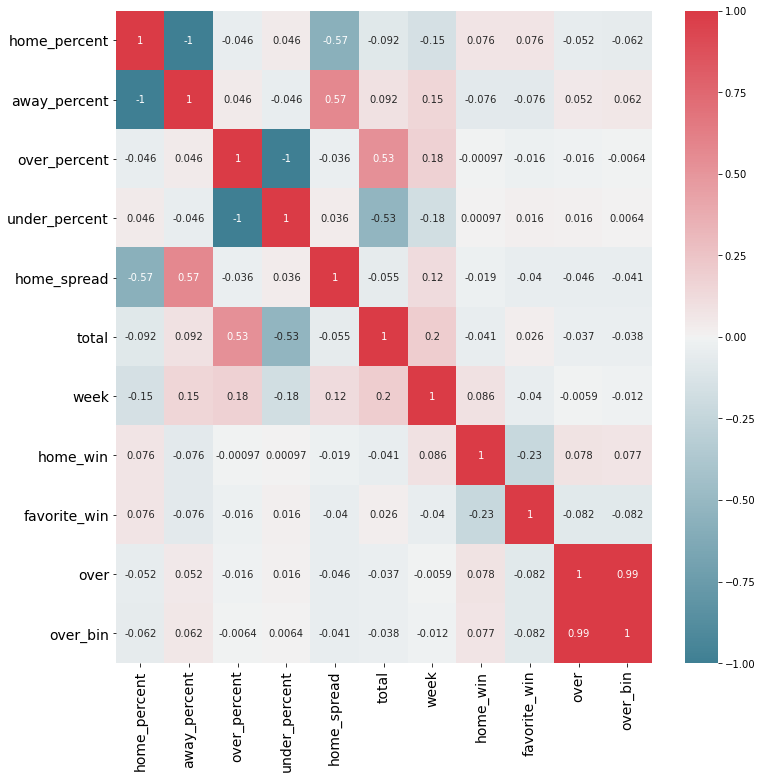

In [9]:
# correlation heatmap
corr_cols = ['home_percent','away_percent','over_percent', 'under_percent', 'home_spread','total',
             'week', 'home_win','favorite_win', 'over', 'over_bin']
corrs = df[corr_cols].corr()

# matplotlib figure size:
fig, ax = plt.subplots(figsize=(12,12))

# mask for the upper triangle
mask = np.zeros_like(corrs, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# plot the heatmap and assign the matplotlib axis
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#ax = sns.heatmap(corrs, mask=mask, annot=True, cmap=cmap, vmin=-1, vmax=1)
ax = sns.heatmap(corrs, annot=True, cmap=cmap, vmin=-1, vmax=1) # no mask
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
plt.show()

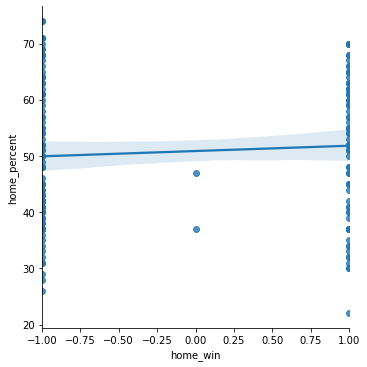

In [10]:
# percent bets vs covers
sns.lmplot(x='home_win', y='home_percent', data=df);

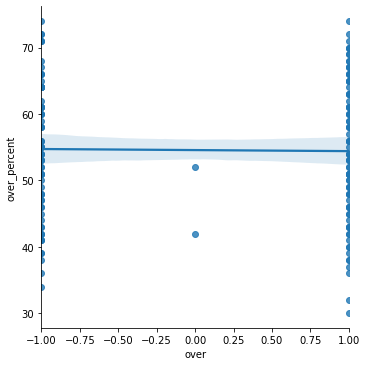

In [11]:
# percent bets vs overs
sns.lmplot(x='over', y='over_percent', data=df);

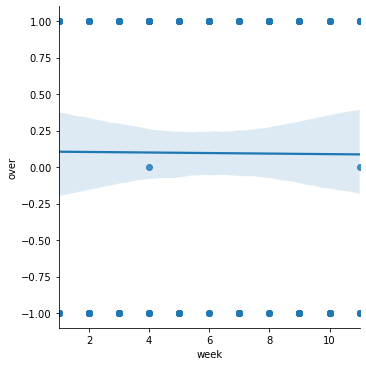

In [12]:
# overs vs week
sns.lmplot(x='week', y='over', data=df);

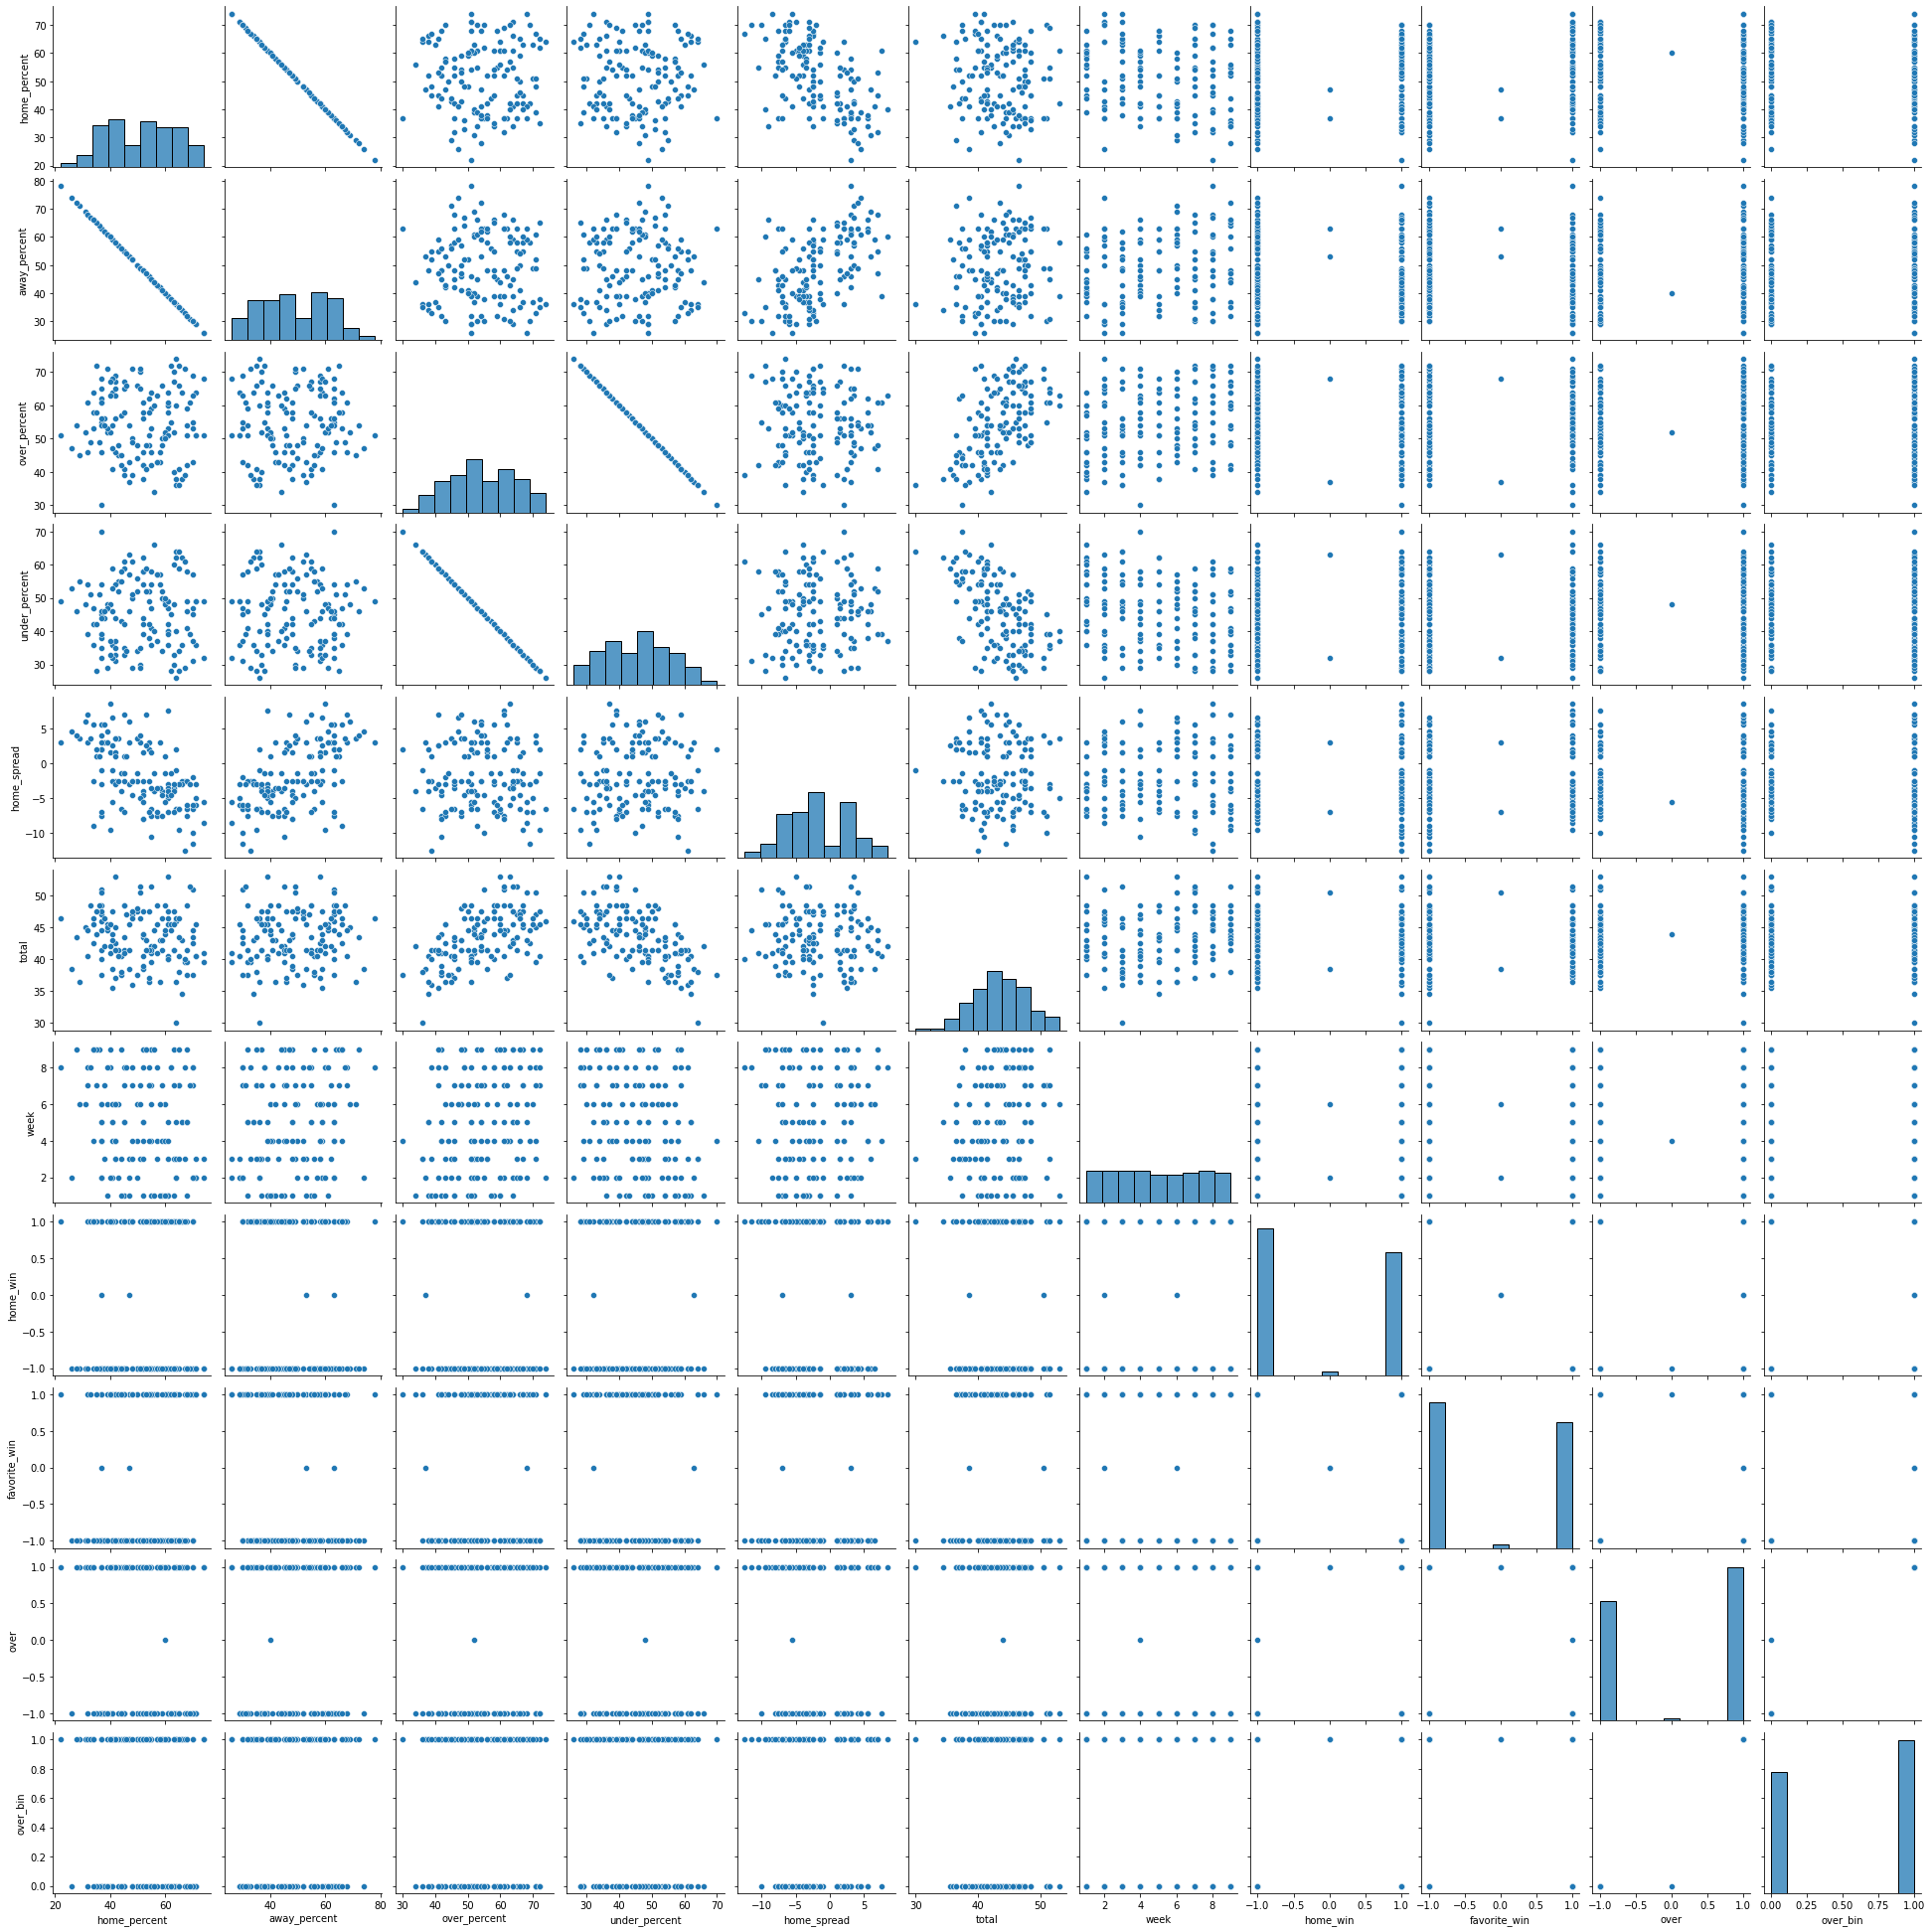

In [25]:
sns.pairplot(df[corr_cols]);

/Users/ccaspar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ccaspar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ccaspar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ccaspar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ccaspar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ccaspar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributi

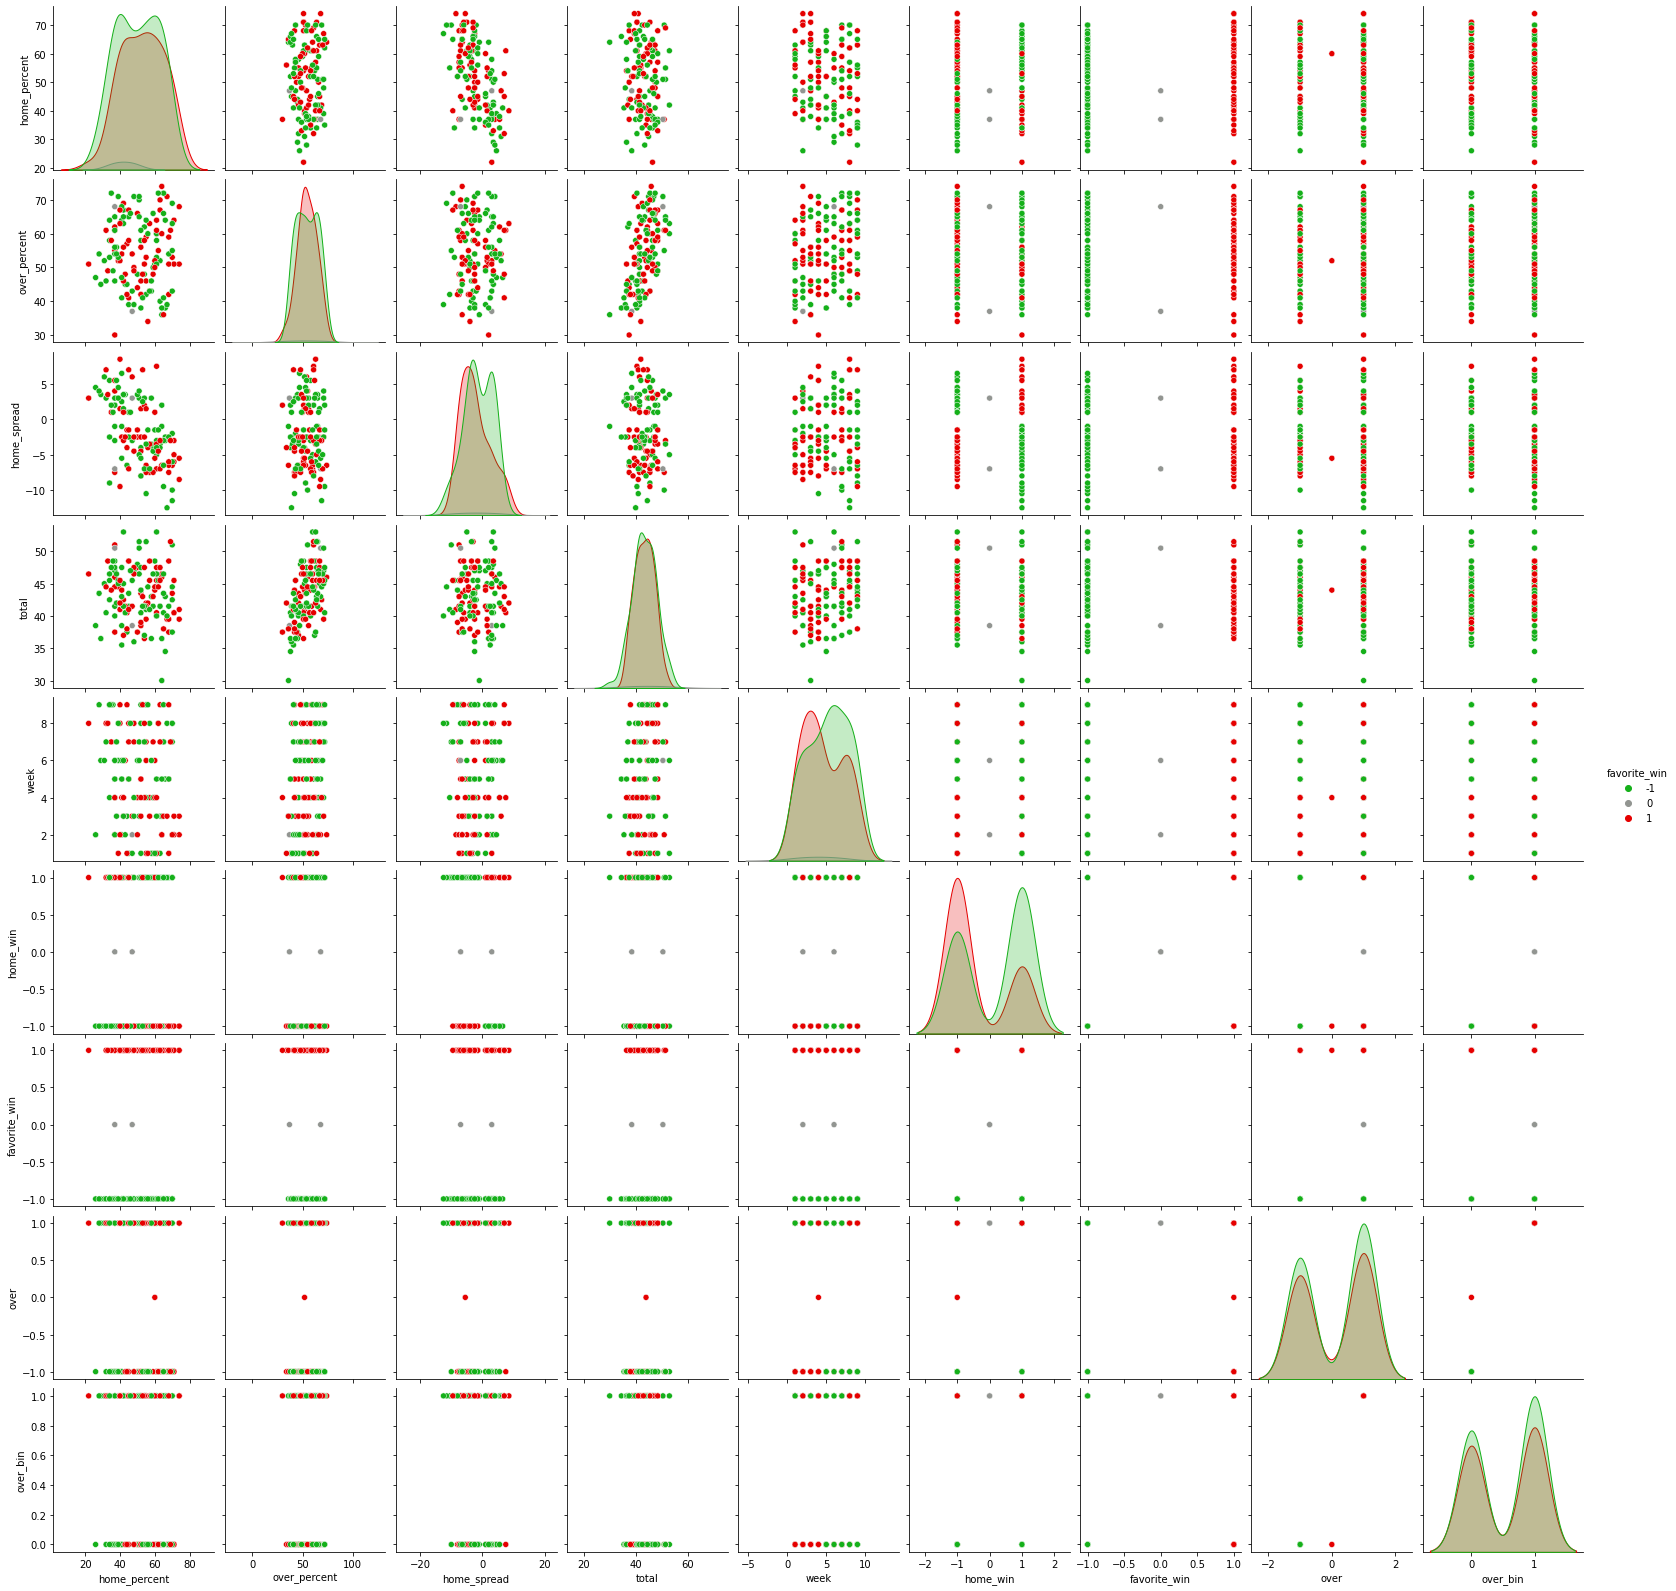

In [32]:
# seaborn style - white background
#sns.set(style="ticks", color_codes=True)
pair_cols = ['home_percent','over_percent','home_spread','total','week','home_win','favorite_win','over','over_bin']
# pairplot with color
pairs = sns.pairplot(df, vars=pair_cols,hue="favorite_win", palette=sns.xkcd_palette(['green', 'grey','red']))

/Users/ccaspar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ccaspar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ccaspar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ccaspar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ccaspar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ccaspar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributi

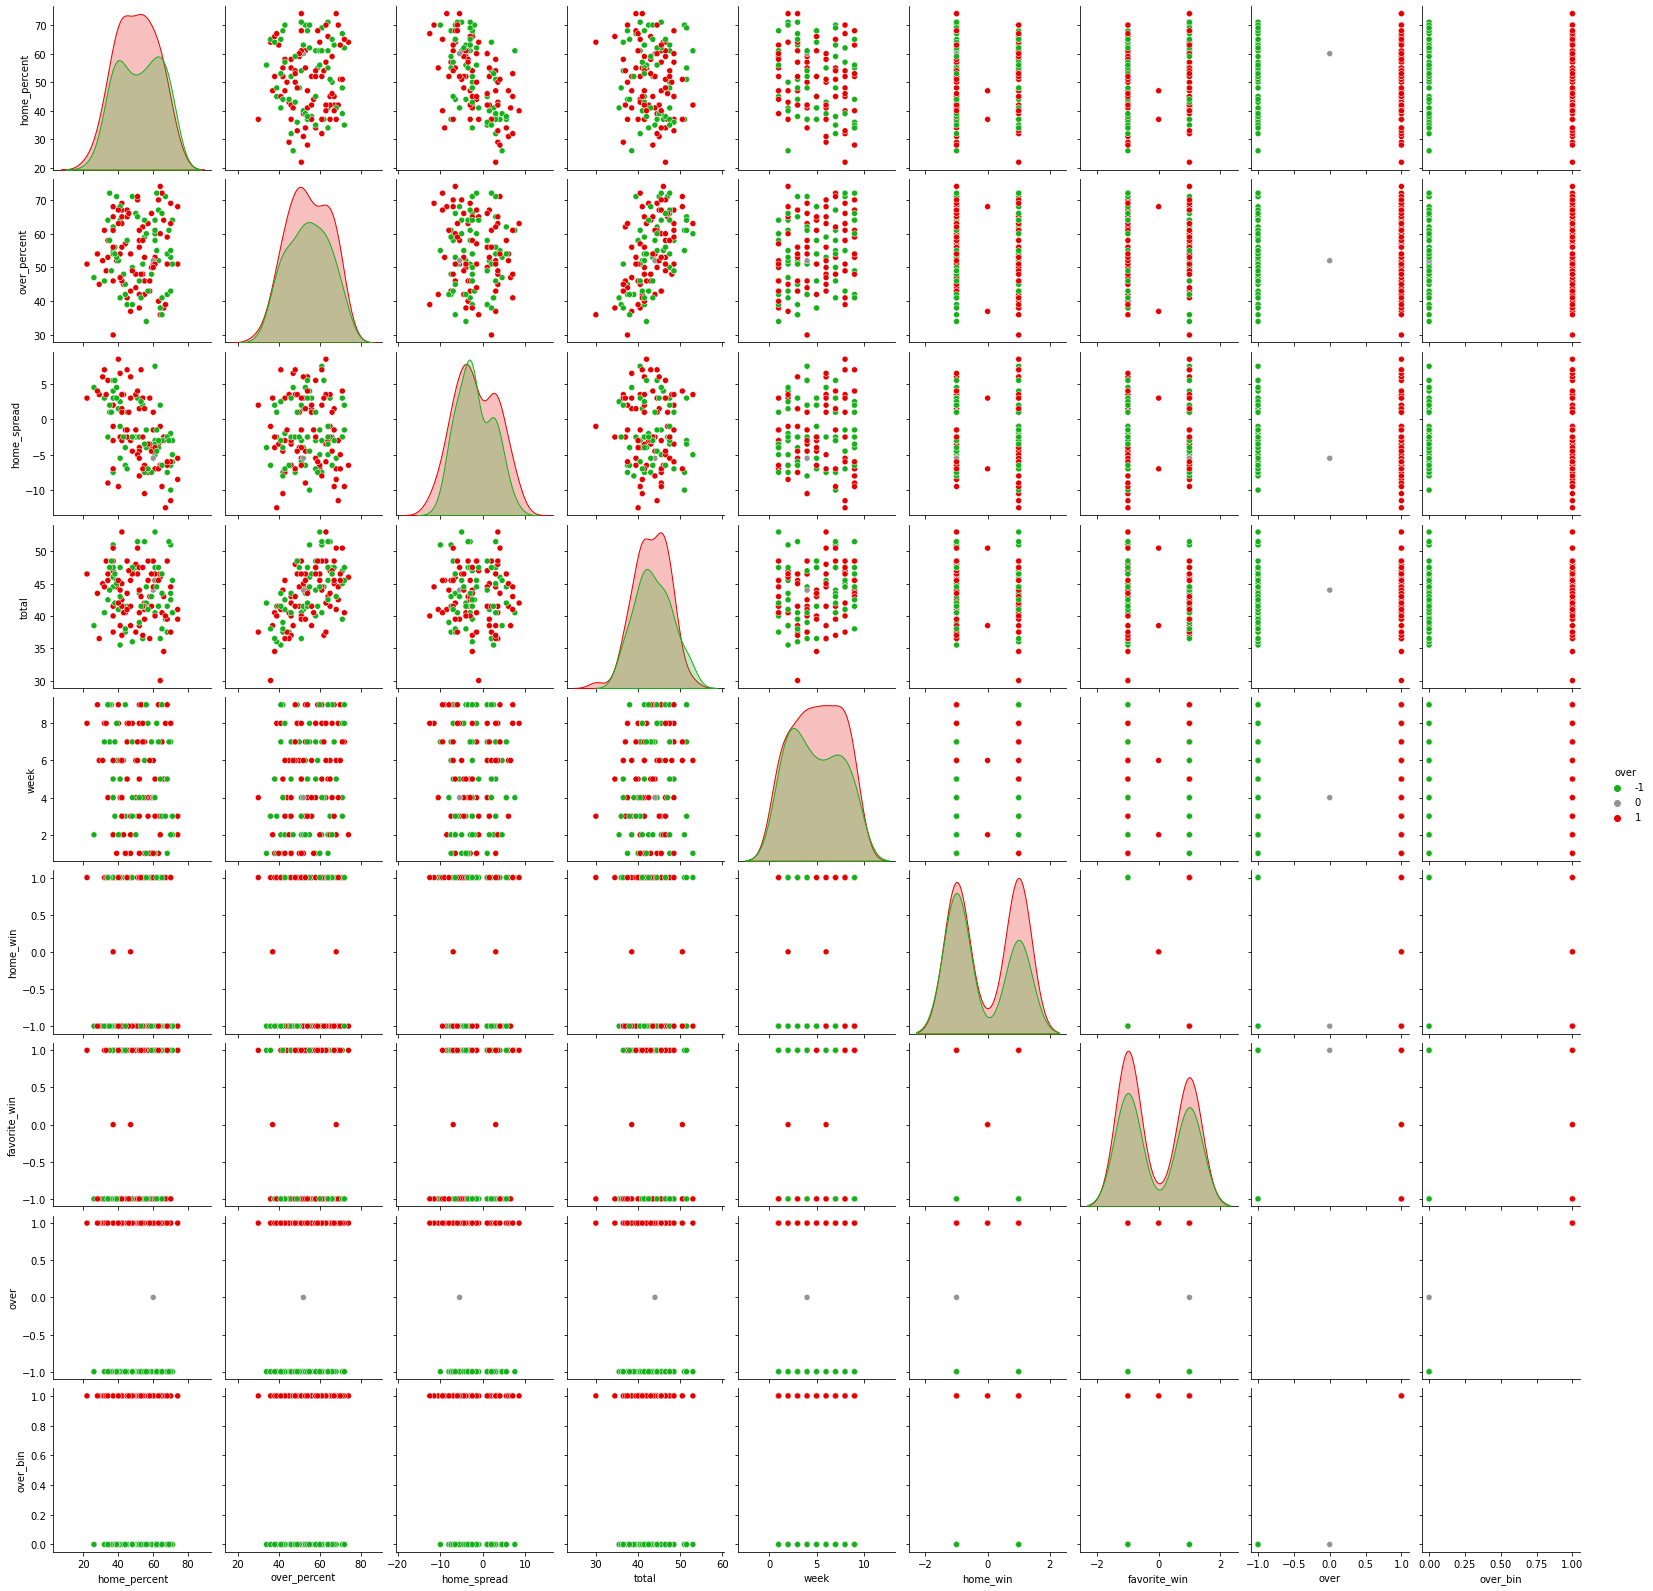

In [33]:
pair_cols = ['home_percent','over_percent','home_spread','total','week','home_win','favorite_win','over','over_bin']
# pairplot with color
pairs = sns.pairplot(df, vars=pair_cols,hue="over", palette=sns.xkcd_palette(['green', 'grey','red']))

/Users/ccaspar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ccaspar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ccaspar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ccaspar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ccaspar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ccaspar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributi

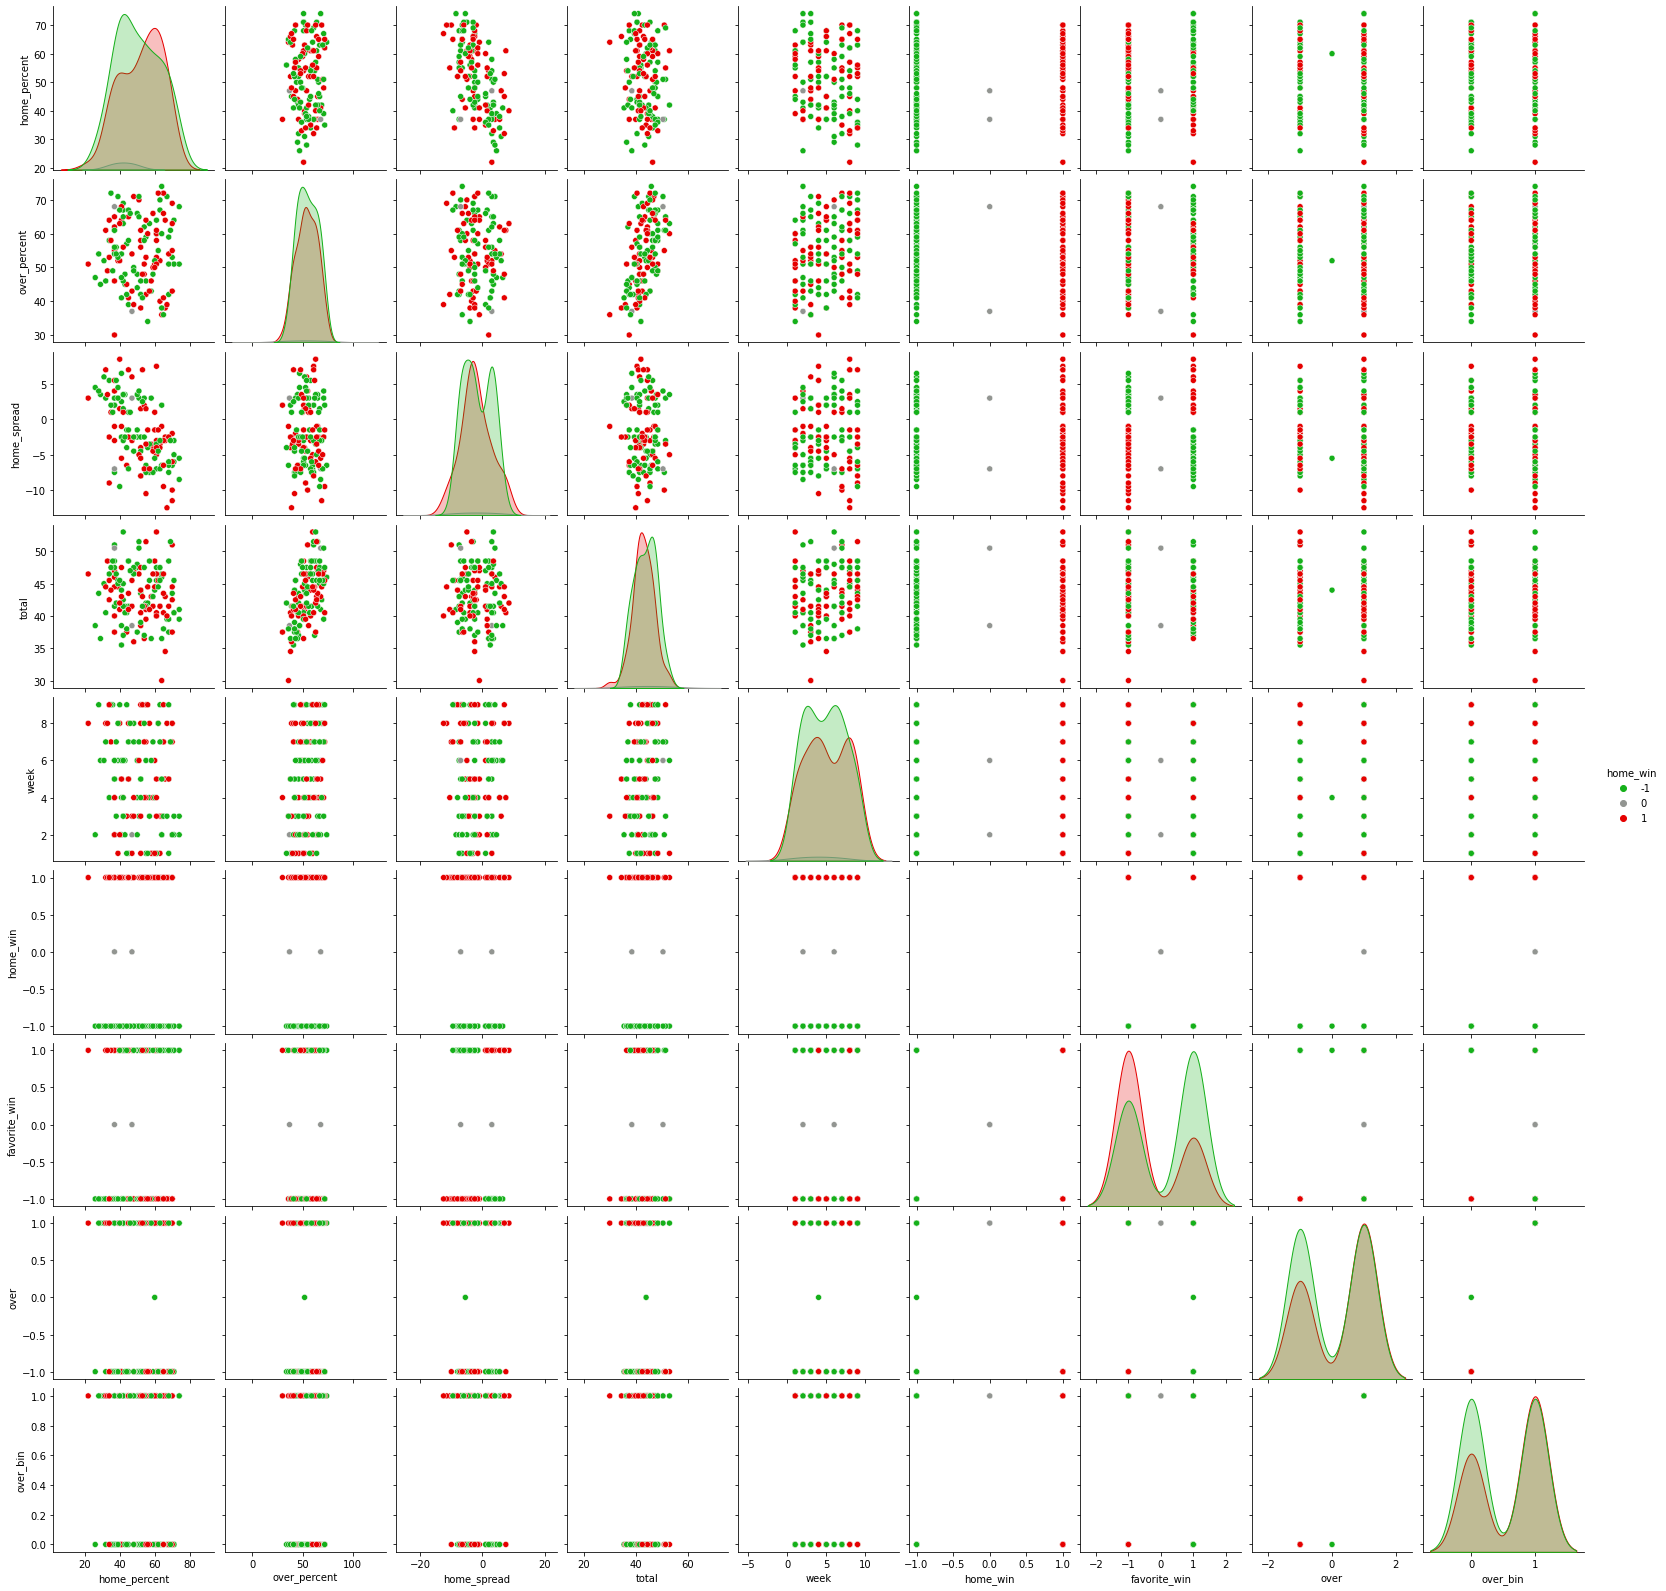

In [34]:
pair_cols = ['home_percent','over_percent','home_spread','total','week','home_win','favorite_win','over','over_bin']
# pairplot with color
pairs = sns.pairplot(df, vars=pair_cols,hue="home_win", palette=sns.xkcd_palette(['green', 'grey','red']))

In [37]:
bins = [0,10,20,30,50,70,80,90,100]
df['count'] = 1
df['home_perc_bin'] = pd.cut(df['home_percent'], bins)
df['over_perc_bin'] = pd.cut(df['over_percent'], bins)

In [ ]:
agg({'home_win_bin': 'mean', 'count': 'sum'})

In [44]:
df[['home_perc_bin', 'home_win_bin', 'count']].groupby('home_perc_bin', as_index=False).agg({'home_win_bin': 'mean', 'count': 'sum'}).fillna(0)

,home_perc_bin,home_win_bin,count
0,"(0, 10]",0.000000,0
1,"(10, 20]",0.000000,0
2,"(20, 30]",0.500000,6
3,"(30, 50]",0.575342,73
4,"(50, 70]",0.524390,82
5,"(70, 80]",0.400000,5
6,"(80, 90]",0.000000,0
7,"(90, 100]",0.000000,0


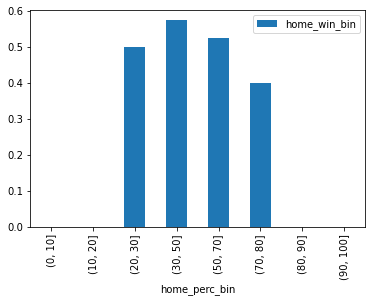

In [35]:
df[['home_perc_bin', 'home_win_bin']].groupby('home_perc_bin', as_index=False).mean().fillna(0).plot.bar(x='home_perc_bin',y='home_win_bin')
plt.show() 

In [46]:
df[['over_perc_bin', 'over_bin', 'count']].groupby('over_perc_bin', as_index=False).agg({'over_bin': 'mean', 'count': 'sum'}).fillna(0)

,over_perc_bin,over_bin,count
0,"(0, 10]",0.000000,0
1,"(10, 20]",0.000000,0
2,"(20, 30]",1.000000,1
3,"(30, 50]",0.553571,56
4,"(50, 70]",0.550000,100
5,"(70, 80]",0.333333,9
6,"(80, 90]",0.000000,0
7,"(90, 100]",0.000000,0


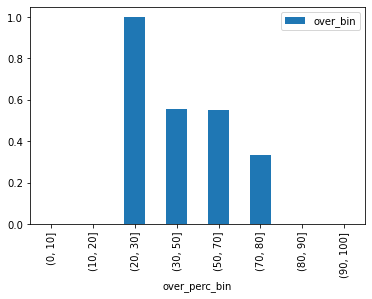

In [42]:
df[['over_perc_bin', 'over_bin']].groupby('over_perc_bin', as_index=False).mean().fillna(0).plot.bar(x='over_perc_bin',y='over_bin')
plt.show() 

In [ ]:
# next: pull total history/movement if possible
line_url = list(line_links)[0]
line_soup = scrape_for_soup(base_url, line_url)

In [15]:
div = game_soup.find('div', class_='row GameMatchup_mainColumn__cILb0')
print(div)

<div class="row GameMatchup_mainColumn__cILb0"><aside class="col-12 col-lg-3"><div class="mt-2"><h2 class="d-flex align-items-center justify-content-between mb-0 py-1 px-3 bg-dark h4" data-bs-theme="dark">Betting Consensus</h2><div class="d-flex justify-content-center pt-2"><div class="col-4 d-flex flex-column justify-content-center text-center text-primary fx-bold pb-3 GameMatchup_TeamName__hOY6B"><p class="h4">Dallas<br/>Cowboys</p><span class="h5 mb-2 text-secondary opacity-75">+5.5</span></div><div class="d-flex justify-content-center align-items-center mx-2 mt-4 rounded-circle fs-7 text-white bg-dark text-center GameMatchup_TagCircle__FABto">vs</div><div class="col-4 d-flex flex-column justify-content-center text-center text-primary fx-bold pb-3 GameMatchup_TeamName__hOY6B"><p class="h4">San Francisco<br/>49ers</p><span class="h5 mb-2 text-secondary opacity-75">-5.5</span></div></div><div class="d-flex flex-column w-100 border-top undefined Rows_Rows__wF9TM"><div class="d-flex ali

<br><br><br><br><br><br>
#### Graveyard

In [ ]:
# iterate through each link to scrape target data
game_url = list(main_links)[0]
# send request
game_soup = scrape_for_soup(base_url, game_url)

# spread bets
spread = game_soup.find('div', text=re.compile('Spread'))
home_perc = spread.next_sibling.get_text()[:-1]
away_perc = spread.previous_sibling.get_text()[:-1]

# over/under bets
total_bets = game_soup.find('div', text=re.compile('Total'))
over_perc = total_bets.previous_sibling.get_text()[:-3]
under_perc = total_bets.next_sibling.get_text()[:-3]
# pull total
tot_div = game_soup.find('div', class_='row GameMatchup_mainColumn__cILb0')
# find the span that contains the best total for the over and strip the first element (second element is odds if needed)
total = float(tot_div.find('h4', text='Over').find_parent('div').find_next_sibling('div').find('span').contents[0].strip())

# teams and spread
away_div = game_soup.find('div', class_=re.compile('TeamName'))
home_div = game_soup.find('div', class_=re.compile('TeamName')).findNext('div', class_=re.compile('TeamName'))
home_team = re.findall('.+?(?=\+|-|PK)',home_div.get_text())[0]
away_team = re.findall('.+?(?=\+|-|PK)',away_div.get_text())[0]
away_spread = away_div.find(text=re.compile('\+?\-?\d+\.?\d*'))
home_spread = home_div.find(text=re.compile('\+?\-?\d+\.?\d*'))
print(f'The spread is {home_spread}')
print(f'% bets {home_team} {home_spread}: {home_perc}')
print(f'% bets {away_team} {away_spread} % bets: {away_perc} \n')
print(f'The total is {str(total)}')
print(f'% bets over {str(total)}: {over_perc}')
print(f'% bets under {str(total)}:{under_perc}')